In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [ ]:
import chainer
from chainer import datasets
from chainer import functions as F
from chainer import links as L
from chainer import Variable
from chainer.backends import cuda
from sklearn.model_selection import train_test_split
import nltk
import re
import gensim
from tqdm import tqdm
import gc

In [ ]:
xp = cuda.cupy
wnl = nltk.stem.WordNetLemmatizer()
head_check = re.compile('^[A-Z][^A-Z]+$')

In [ ]:
MIN_COUNT = 10
BATCH_SIZE = 128
MAX_EPOCH = 3
# length of truncated BPTT
BPROP_LEN = 20
VECTOR_SIZE = 300

In [ ]:
%%time
train_df = pd.read_csv("../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv")
test_df = pd.read_csv("../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv")
all_df = pd.concat([train_df['comment_text'], test_df['comment_text']])

y= np.where(train_df['target']>=0.5, 1, 0)
y = y.astype(np.int32)


In [ ]:
t_all = []
for s in tqdm(all_df.values):
    t_all.append(nltk.word_tokenize(s))

del all_df
del train_df
del test_df
gc.collect()

In [ ]:
s_all = []

for i in range(len(t_all)):
    vector = []
    for t in t_all[i]:
        check = head_check.match(t)
        if check is not None:
            add = t[0].lower() + t[1:]
        else:
            add = t
        vector.append(wnl.lemmatize(add))
    s_all.append(vector)

del t_all
del head_check
gc.collect()

In [ ]:
len(s_all), s_all[0]

In [ ]:
word2vec = gensim.models.word2vec.Word2Vec.load('../input/word2vec-model/word2vec.model')

In [ ]:
t_train = []
t_pre = []
for i in range(len(y)):
    t_train.append(s_all[i])
for i in range(len(y),len(s_all)):
    t_pre.append(s_all[i])

del s_all
gc.collect()

In [68]:
y_df = pd.DataFrame(y, columns=['y'])
y_tf = y_df==0
y0 = y_tf.sum()
y0 = y0[0]
y1 = len(y_df)-y0
y0, y1

(1660540, 144334)

In [40]:
np.random.binomial(128, 0.5)

58

In [75]:
y_sort = y_df.sort_values('y', ascending=False)
y1_df = pd.DataFrame(y_sort[0:y1], columns=['y1'])
y0_df = pd.DataFrame(y_sort[y1:], columns=['y0'])

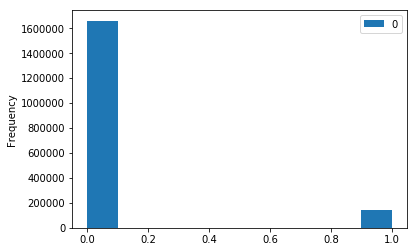

In [34]:
y_df.plot.hist()

In [ ]:
zero = np.zeros((VECTOR_SIZE,), dtype=np.float32)
X = []
for i in range(len(t_train)):
    vector = []
    for s in t_train[i]:
        try:
            vector.append(word2vec[s])
        except KeyError:
            vector.append(zero)
    X.append(vector)
    
del t_train
# del vector
gc.collect()

In [ ]:
max_len_train = max(list(map(len, X)))
max_len_test = max(list(map(len, X_pre)))
max_len = max_len_train if max_len_train>max_len_test else max_len_test
del max_len_train
del max_len_test

for i in range(len(X)):
    diff = max_len - len(X[i])
    for j in range(diff):
        X[i].append(zero)


In [ ]:
# i2w = word2vec.wv.index2word
# words = {w: i for i, w in enumerate(i2w)}

# for i in range(len(t_all)):
#     for word in t_all[i]:
#         if word not in words:
#             words[word] = -1

# del t_all

# X = []
# for j in range(len(t_train)):
#     vector = []
#     for word in t_train[j]:
#         try:
#             vector.append(words[word])
#         except KeyError:
#             words[word] = -1
#             vector.append(words[word])
#     vector = np.array(vector, dtype=np.int32)
#     X.append(vector)

# X_pre = []
# for j in range(len(t_pre)):
#     vector = []
#     for word in t_pre[j]:
#         try:
#             vector.append(words[word])
#         except KeyError:
#             words[word] = -1
#             vector.append(words[word])
#     vector = np.array(vector, dtype=np.int32)
#     X_pre.append(vector)

# del t_train
# del t_pre
# del words
# del vector

In [ ]:
# max_len_train = max(list(map(len, X)))
# max_len_test = max(list(map(len, X_pre)))
# max_len = max_len_train if max_len_train>max_len_test else max_len_test
# del max_len_train
# del max_len_test

# for i in range(len(X)):
#     add = np.zeros((max_len-len(X[i])), dtype=np.int32)
#     X[i] = np.append(X[i], add)

# for i in range(len(X_pre)):
#     add = np.zeros((max_len-len(X_pre[i])), dtype=xp.int32)
#     X_pre[i] = np.append(X_pre[i], add)

# del add

In [ ]:
class jigsaw_dataset(chainer.dataset.DatasetMixin):
    def __init__(self, X, y, train=True, train_size=0.6):
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, train_size=train_size, random_state=1)
        self.n_train = len(self.y_train)
        self.n_test = len(self.y_test)
        self.train = train
        self.train_size=train_size
    
    def __len__(self):
        if self.train:
            return self.n_train
        else:
            return self.n_test
    
    def get_example(self, i):
        if self.train:
            train = datasets.tuple_dataset.TupleDataset(self.X_train, self.y_train)
            return train[i]
        else:
            test = datasets.tuple_dataset.TupleDataset(self.X_test, self.y_test)
            return test[i]

In [ ]:
len(X[0]), len(X[1]), len(X_pre[0]), len(X_pre[1])

In [ ]:
# class RNN(chainer.Chain):
#     def __init__(self, n_vocab=1000, n_units=100, w=None):
#         super(RNN, self).__init__(
#             embed = L.EmbedID(n_vocab, n_units, initialW=w),
#             l1 = L.LSTM(None, n_units),
#             l2 = L.LSTM(None, n_units),
#             l3 = L.Linear(None, 2)
#         )
    
#     def reset_state(self):
#         self.l1.reset_state()
#         self.l2.reset_state()

#     def forward(self, x):
#         print(x)
#         h0 = self.embed(x)
#         h1 = self.l1(F.dropout(h0))
#         h2 = self.l2(F.dropout(h1))
#         y = F.softmax(self.l3(h2))
#         return y


# model = L.Classifier(RNN(n_vocab=word2vec.wv.vectors.shape[0],n_units=word2vec.wv.vectors.shape[1], w=word2vec.wv.vectors))

# gpu_id = 0
# if gpu_id >= 0:
#     model.to_gpu(gpu_id)
    
# optimizer = chainer.optimizers.Adam()
# optimizer.setup(model)
# optimizer.add_hook(chainer.optimizer.GradientClipping(5))

In [ ]:
class RNN(chainer.Chain):
    def __init__(self, n_units=300):
        super(RNN, self).__init__(
            l1 = L.LSTM(None, n_units),
            l2 = L.LSTM(None, n_units),
            l3 = L.Linear(None, 2)
        )
    
    def reset_state(self):
        self.l1.reset_state()
        self.l2.reset_state()

    def forward(self, x):
        h0 = self.l1(F.dropout(x))
        h1 = self.l2(F.dropout(h1))
        y = F.softmax(self.l3(h2))
        return y


model = L.Classifier(RNN(n_units=300))

gpu_id = 0
if gpu_id >= 0:
    model.to_gpu(gpu_id)
    
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer.GradientClipping(5))

In [ ]:
train = jigsaw_dataset(X, y)
test = jigsaw_dataset(X, y, train=False)
del X
del y
train_iter = chainer.iterators.SerialIterator(train, BATCH_SIZE)
test_iter = chainer.iterators.SerialIterator(test, BATCH_SIZE, repeat=False, shuffle=False)
del train
del test

In [ ]:
def evaluate(model, iter, gpu_id):
    evaluator = model.copy()
    evaluator.predictor.reset_state()
    sum_perp = 0
    data_count = 0
    with chainer.configuration.using_config('train', False):
        with chainer.using_config('enable_backprop', False):
            iter.reset()
            for batch in iter:
                sentence, target = chainer.dataset.convert.concat_examples(batch, gpu_id)
                loss = evaluator(sentence, target)
                sum_perp += loss.array
                data_count += 1
    return np.exp(float(sum_perp) / data_count)

In [ ]:
%%time
sum_perp = 0
count = 0
iteration = 0
while train_iter.epoch < MAX_EPOCH:
        loss = 0
        iteration += 1
        for i in range(BPROP_LEN):
            train_batch = train_iter.__next__()
            sentence_train, target_train = chainer.dataset.convert.concat_examples(train_batch, gpu_id)
            loss += optimizer.target(sentence_train, target_train)
            if train_iter.is_new_epoch:
                break
        count += 1
        sum_perp += loss.array
        optimizer.target.cleargrads()
        loss.backward()
        loss.unchain_backward()
        optimizer.update()
        print(count)
        # 1082924
        if train_iter.is_new_epoch:
            print('epoch:{}'.format(train_iter.epoch))
            print('test perplexity:{}'.format(evaluate(model, test_iter, gpu_id)))
del train_iter
del test_iter

In [ ]:
X_pre = []
for i in range(len(t_pre)):
    vector = []
    for s in t_pre[i]:
        try:
            vector.append(word2vec[s])
        except KeyError:
            vector.append(zero)
    X_pre.append(vector)

del t_pre

for i in range(len(X_pre)):
    diff = max_len - len(X_pre[i])
    for j in range(diff):
        X_pre[i].append(zero)
        

In [ ]:
def predictor(model, X_pre):
    prediction_cpu = []
    with chainer.configuration.using_config('train', False):
        with chainer.using_config('enable_backprop', False):
            for i in range(len(X_pre)):
#                 print(i)
                p = xp.array([X_pre[i]])
                prediction = model.predictor(p)
                del p
                p_cpu = cuda.to_cpu(prediction.array)
                del prediction
                prediction_cpu.append(p_cpu)
    return prediction_cpu

In [ ]:
prediction_cpu = predictor(model, X_pre)

In [ ]:
word_length

In [ ]:
pre_df = pd.read_csv("../input/sample_submission.csv")
pre_df.head()

In [ ]:
%%time
for i in range(len(prediction_cpu)):
    p = np.where(prediction_cpu[i][0][0] > prediction_cpu[i][0][1], 0, 1)
    pre_df.loc[i, 'prediction'] = p

In [ ]:
pre_df['prediction'].unique()

In [ ]:
pre_df.to_csv('submission.csv', index=False)